Reference : https://pubs.acs.org/doi/full/10.1021/jacsau.1c00035

            강원대 이주용 교수님 인공지능과 화학

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In [ ]:
import condacolab
condacolab.check()

In [ ]:
! conda create -n Smiles
! activate Smiles 

Solving environment: - done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local/envs/Smiles



Preparing transaction: | done
Verifying transaction: - done
Executing transaction: | done
#
# To activate this environment, use
#
#     $ conda activate Smiles
#
# To deactivate an active environment, use
#
#     $ conda deactivate

Retrieving notices: ...working... done


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # tqdm : 진행상황을 progress bar로 시각화 한 라이브러리

In [ ]:
!mamba install -c conda-forge rdkit

import rdkit
import rdkit.Chem
from rdkit.Chem import AllChem


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['rdkit']

conda-forge/linux-64                                        Using cache
conda-forge/noarc

In [ ]:

# Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference
# ['1', 'N#Cc1cc2ccc(O)cc2oc1=O', 'O', '355', '410', '2.804262479', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', '187.1537', 'DOI: 10.1021/acs.jpcb.5b09905']
# dat[2] : Solvent
# dat[3] : Absorption Max (nm)
smiles = []
abs_max_list = []
path = '/content/drive/MyDrive/Colab Notebooks/인공지능 공부/Portfolio/DB for chromophore_Sci_Data_rev02.csv의 사본'

for l in tqdm(open(path).readlines()[1:]) : 
    dat = l.strip().split(',')
    # dat[2] =='ClCCl' :  Dichlorometyl을 solvent로 하는 분자 데이터가 가장 많고, 
    # dat[3] != 'NaN' : 최대 흡광 파장을 예측하는 모델을 만들 것이기 때문에 데이터가 없는 라인은 skip
    if dat[2] =='ClCCl' and dat[3] != 'NaN' : #select the cases where solvent is dichloromethane.
        # dat[1] : SMILES 표기식
        smiles.append(dat[1]) 
        # 최대 흡광파장을 저장
        abs_max_list.append(float(dat[3]))

print()
print(f'Number of SMILES strings : {len(smiles)}')
print(f'Number of Abs_Max : {len(abs_max_list)}')

100%|██████████| 20236/20236 [00:00<00:00, 684472.31it/s]


Number of SMILES strings : 2429
Number of Abs_Max : 2429


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, Dataset
from sklearn.model_selection import train_test_split

torch.manual_seed(52)

In [ ]:
X = []
for smi in tqdm(smiles) : 
    mol = rdkit.Chem.MolFromSmiles(smi)
    vec = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits= 1024)
    X.append(vec.ToList())

# mol, 2=radius (중심원자로부터 2번 떨어진 거리 만큼을 functional group으로 취급), nBits=1024 : 1024개의 0과 1개로 표현


100%|██████████| 2429/2429 [00:01<00:00, 1354.22it/s]


In [ ]:
X = torch.Tensor(X)
y = torch.Tensor(abs_max_list).view(-1, 1)
print(X.shape, y.shape)

torch.Size([2429, 1024]) torch.Size([2429, 1])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
batch_size = 64
lr = 1e-3
weight_decay = 1e-5
epochs = 1000

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=52)

train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)

val_dataset = TensorDataset(x_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False, drop_last = True)

test_dataset = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

In [ ]:
class CustomModel(nn.Module) : 
    def __init__(self, initial=1024, hd1=256, hd2=128, hd3=32, output=1) : 
        super(CustomModel, self).__init__()
        self.linear_stack = nn.Sequential(

            nn.Linear(initial, hd1),
            nn.BatchNorm1d(hd1),
            nn.GELU(),
            nn.Dropout(0.5),
            
            nn.Linear(hd1, hd1),
            nn.BatchNorm1d(hd1),
            nn.GELU(),
            nn.Dropout(0.5),
                        
            nn.Linear(hd1, hd2),
            nn.BatchNorm1d(hd2),
            nn.GELU(),
            nn.Dropout(0.5),
                        
            nn.Linear(hd2, hd2),
            nn.BatchNorm1d(hd2),
            nn.GELU(),
            nn.Dropout(0.5),
                        
            nn.Linear(hd2, hd3),
            nn.BatchNorm1d(hd3),
            nn.GELU(),
            nn.Dropout(0.2),
            
            nn.Linear(hd3, output)
        )

    def forward(self, x) : 
        return self.linear_stack(x)

In [ ]:
class DNN() : 
    def __init__(self, batch_size, model, loss_fn, optimizer) : 
        self.batch_size = batch_size
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def train(self, epochs, train_dataloader, val_dataloader, period=100) : 
        train_loss_list = []
        val_loss_list = []

        for epoch in range(1, epochs + 1) : 
            epoch_train_loss = 0

            for X, y in train_dataloader : 
                X, y = X.to(device), y.to(device)

                pred = self.model(X)
                train_loss = self.loss_fn(pred, y)

                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()

                epoch_train_loss += train_loss.item()


            self.model.eval()
            epoch_val_loss = 0

            with torch.no_grad() : 
                for X, y in val_dataloader : 
                    X, y = X.to(device), y.to(device)

                    pred = self.model(X)
                    val_loss = self.loss_fn(pred, y)

                    epoch_val_loss += val_loss.item()

            epoch_train_loss /= len(train_dataloader)
            epoch_val_loss /= len(val_dataloader)

            train_loss_list.append(epoch_train_loss)
            val_loss_list.append(epoch_val_loss)

            if epoch % period == 0 : 
                print(f'Epoch  {epoch} / {epochs} \t\t train_loss : {epoch_train_loss:.4f} \t\t val_loss : {epoch_val_loss:.4f}')
        
        return train_loss_list, val_loss_list


    def test(self, test_dataloader) : 
        loss = 0

        self.model.eval()

        for X, y in test_dataloader : 
            X, y = X.to(device), y.to(device)

            pred = self.model(X)
            test_loss = self.loss_fn(pred, y)

            loss += test_loss

        loss /= len(test_dataloader)
        print(f'Test Loss : {loss:.4f}')

In [ ]:
model = CustomModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

trial = DNN(batch_size, model, loss_fn, optimizer)

In [ ]:
train_loss_list, val_loss_list = trial.train(epochs, train_dataloader, val_dataloader, period=100)

Epoch  100 / 1000 		 train_loss : 60.8401 		 val_loss : 1391.6101
Epoch  200 / 1000 		 train_loss : 41.9253 		 val_loss : 1232.6694
Epoch  300 / 1000 		 train_loss : 29.7621 		 val_loss : 1294.1014
Epoch  400 / 1000 		 train_loss : 23.2515 		 val_loss : 1295.3495
Epoch  500 / 1000 		 train_loss : 18.1363 		 val_loss : 1300.9361
Epoch  600 / 1000 		 train_loss : 17.9219 		 val_loss : 1304.3878
Epoch  700 / 1000 		 train_loss : 17.9883 		 val_loss : 1302.9040
Epoch  800 / 1000 		 train_loss : 36.1946 		 val_loss : 1289.1282
Epoch  900 / 1000 		 train_loss : 15.3604 		 val_loss : 1308.5284
Epoch  1000 / 1000 		 train_loss : 31.3662 		 val_loss : 1361.8464


In [ ]:
def loss_graph(epochs, train_loss_list, val_loss_list) : 
    epoch_count = range(epochs)

    plt.plot(epoch_count, train_loss_list, label='Train Loss')
    plt.plot(epoch_count, val_loss_list, label='Val Loss')
    plt.title('Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()

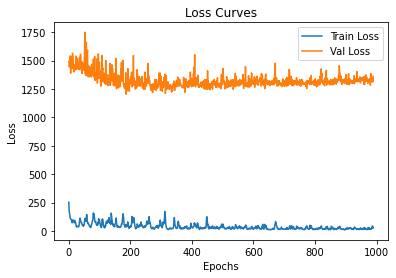

In [ ]:
#과적합
loss_graph(epochs-10, train_loss_list[10:], val_loss_list[10:])

In [ ]:
trial.test(test_dataloader)

Test Loss : 1302.8132


In [ ]:
preds = model(x_test.to(device)).cpu().view(-1).detach().numpy()
y_true = y_test.view(-1).detach().numpy()
print(preds.shape, y_true.shape)

(486,) (486,)


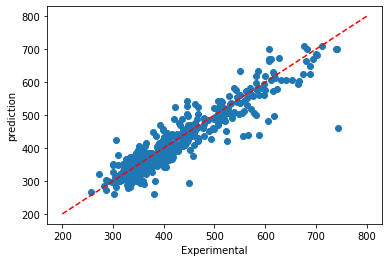

In [92]:
plt.xlabel('Experimental')
plt.ylabel('prediction')

line = [200, 800]

plt.scatter(y_true, preds)
plt.plot(line, line, 'r--')

In [ ]:
corr = np.corrcoef(preds, y_true)
print(f'Correlation of prediction & Experimental data : {corr[0][1]*100:.2f} %')

Correlation of prediction & Experimental data : 93.09 %


In [ ]:
from pathlib import Path

#모델을 저장하기위한 경로 설정 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#모델을 해당 위치에 저장하기위한 경로, 이름 설정
MODEL_NAME = "ECFP_absmax_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"모델 저장 위치와 파일명: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

모델 저장 위치와 파일명: models/ECFP_absmax_model.pth


In [ ]:
# 모델이 잘 저장되었는지 확인하기
!ls -l models/ECFP_absmax_model.pth

-rw-r--r-- 1 root root 1552316 Mar  4 13:37 models/ECFP_absmax_model.pth


In [ ]:
# 모델의 구조를 알도록 정의한 모델을 생성한다.
loaded_model = CustomModel()

# 다음 행에서 학습된 모델의 파라미터를 모델이 저장된 경로에서 불러온다.
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
# 불러온 모델이 잘 예측하는지 테스트 해보자.
loaded_model.eval()

# 모델 학습 과정에서 예측을 생성할때와 같이 불러온 모델로 예측 생성해보기
with torch.inference_mode():
    loaded_model_preds = loaded_model(x_test).view(-1).detach().numpy()
print(preds[:10])
print(loaded_model_preds[:10])

[574.3458  342.20444 385.28366 594.40924 350.7719  360.46353 492.28763
 463.81506 348.9337  623.7233 ]
[574.34576 342.20444 385.28366 594.4093  350.77197 360.46353 492.28763
 463.81506 348.93372 623.7234 ]
